In [1]:
#https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [2]:
from torch import nn, Tensor
import torch.nn.functional as F
import torch
import math
from torch.autograd.variable import Variable
import typing
import random
import tqdm
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
import os

modelname="4_30_23_m1"

prefix_models="models/"+modelname+"/"

if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        #mine is [batch, seq, embed]
        x = x.permute((1,0,2))
        x = x + self.pe[:x.size(0)]
        dropout = self.dropout(x)
        return dropout.permute((1,0,2))

In [7]:
class ScaledDotProductAttention(nn.Module):
    def forward(self, query, key, value, mask = None):
        key_tp = key.transpose(-2, -1)

        scores = query.matmul(key_tp) / math.sqrt(query.size()[-1])

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))
            
        attention = F.softmax(scores, dim = -1)

        return attention.matmul(value)

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 in_features,
                 head_num,
                 bias=True,
                 activation=F.relu):
        super(MultiHeadAttention, self).__init__()
        if in_features % head_num != 0:
            raise ValueError('`in_features`({}) should be divisible by \
                `head_num`({})'.format(in_features, head_num))
        self.in_features = in_features
        self.head_num = head_num
        self.activation = activation
        self.bias = bias
        self.linear_q = nn.Linear(in_features, in_features, bias)
        self.linear_k = nn.Linear(in_features, in_features, bias)
        self.linear_v = nn.Linear(in_features, in_features, bias)
        self.linear_o = nn.Linear(in_features, in_features, bias)

    def forward(self, q, k, v, mask=None):
        q, k, v = self.linear_q(q), self.linear_k(k), self.linear_v(v)
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)

        q = self._reshape_to_batches(q)
        k = self._reshape_to_batches(k)
        v = self._reshape_to_batches(v)
        
        if mask is not None:
            mask = mask.repeat(self.head_num, 1, 1)   
        
        y = ScaledDotProductAttention()(q, k, v, mask)        
        
        y = self._reshape_from_batches(y)      

        y = self.linear_o(y)
        if self.activation is not None:
            y = self.activation(y)
        return y

    @staticmethod
    def gen_causal_mask(x):
        batch_size, seq_len, _ = x.size()
        return torch.tril(torch.ones(seq_len, seq_len)).view(1, seq_len, seq_len).repeat(batch_size, 1, 1)

    def _reshape_to_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        sub_dim = in_feature // self.head_num
        return x.reshape(batch_size, seq_len, self.head_num, sub_dim)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size * self.head_num, seq_len, sub_dim)

    def _reshape_from_batches(self, x):
        batch_size, seq_len, in_feature = x.size()
        batch_size //= self.head_num
        out_dim = in_feature * self.head_num
        return x.reshape(batch_size, self.head_num, seq_len, in_feature)\
                .permute(0, 2, 1, 3)\
                .reshape(batch_size, seq_len, out_dim)

In [9]:
class Transformer(nn.Module):
    def __init__(self, 
                 embedding_dim: int,
                 n_self_heads: int,
                 n_features: int,
                 n_layers: int,
                 n_classes: int):
        super().__init__()

        #Embedding layer
        self.embedding = nn.Embedding(n_features, embedding_dim)
        #Positional encoding
        self.pos_encode = PositionalEncoding(embedding_dim)

        self.decoder_layers = []

        for _ in range(n_layers):
            layer = []
            #Add multihead, which will be cross or self attention
            layer.append(MultiHeadAttention(embedding_dim, n_self_heads)) #self attention first, masked
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))
            #Add a feed forward
            layer.append(nn.Linear(embedding_dim, embedding_dim))
            #Now add layer norm
            layer.append(nn.LayerNorm(embedding_dim))

            self.decoder_layers.append(nn.ModuleList(layer))
        self.decoder_layers=nn.ModuleList(self.decoder_layers)

        self.to_out = nn.Linear(embedding_dim, n_classes)
            
    def forward(self, x: torch.Tensor, calculate_loss: bool = False):
        """
        Expect tensor of [batch_size, n_features]
        """
        if calculate_loss:
            #If give model that accepts ?x?x4 abcd, expect bcd0
            
            target_logits=torch.cat([x[:,1:], torch.zeros((x.shape[0],1)).to(device)], dim=-1) ## if x is abcd, then target_logits is bcd0

        x=x.long().to(device)
        embed = self.embedding(x)
        pos_encode = self.pos_encode(embed)

        res = embed+pos_encode
        
        for decoder_layer in self.decoder_layers:
            d_self_attention = decoder_layer[0]
            d_layer_norm_1 = decoder_layer[1]
            d_ff = decoder_layer[2]
            d_layer_norm_2 = decoder_layer[3]
            
            ## Run the decoder
            #do masked self attention
            mask = MultiHeadAttention.gen_causal_mask(res).to(device)
            res = res + d_self_attention(res,res,res, mask = mask)
            self_res = res
            #layer norm
            res = d_layer_norm_1(res)

            #do ff
            res = self_res + d_ff(res)
            #layer norm
            res = d_layer_norm_2(res)

        out = self.to_out(res)
        if calculate_loss:
            loss = nn.functional.cross_entropy(out.permute(0, 2, 1), target_logits.long())
            return out,loss
        return out

In [10]:
def tokenize_multi(text_seq: str, features: int, encoding = "utf8") -> torch.Tensor:
    # tokenize the input text
    sentences = []
    for sentence in filter(lambda x: x!="", text_seq.split("\n")):
        base = list(bytes(sentence, "utf8"))
        if len(base) < features:
            base.extend([0] * (features - len(base)))
        tensor = torch.Tensor(base)
        tensor = tensor.unsqueeze(0)
        sentences.append(tensor)

    return torch.cat(sentences, dim = 0)

def tokenize_single(sentence: str, features: int, encoding = "utf8") -> torch.Tensor:
    base = list(bytes(sentence, "utf8"))
    if len(base) < features:
        base.extend([0] * (features - len(base)))
    tensor = torch.Tensor(base)
    return tensor

In [11]:
def generate(seed: str, cutoff: int = 1024) -> str:
    output = torch.tensor([list(bytes(seed,"utf8"))]).to(device)
    
    res=output
    last = -1
    i=0
    while last != 0 and i<cutoff:
        res = model(output)
        argmax=res.argmax(-1)
        
        out = list(output[0])
        out.append(list(argmax.to(device)[0])[-1])
        last = list(argmax.to(device)[0])[-1]
        output = torch.tensor([out])
        i+=1
    
    if last == 0:
        return convert_to_str(output)
    return convert_to_str(output)+"<CUTOFF>"

In [12]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, data: typing.List[str], features):
        self.raw_data = data
        self.features = features
        
    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self,index):
        return tokenize_single(self.raw_data[index], self.features)

In [13]:
def convert_to_str(x: torch.Tensor) -> str:
    #Expects [1, 256] tensor
    bts = []
    i=0
    while len(bts)<x.shape[1] and x[0][i] != 0:
        bts.append(int(x[0][i]))
        i+=1
    return bytes(bts).decode()

In [14]:
n_features = 256 # No. of tokens
n_pad = 512 # Max line length
embedding_dim = 512
batch_size = 48
head_factor = 64
assert embedding_dim%head_factor == 0
head_size = embedding_dim//head_factor
n_layers = 14

In [15]:
path_to_data = "data/reddit_scrape_v6.txt"
data_raw = open(path_to_data, encoding="utf-8").read()

data_split = list(filter(lambda x: x!="", data_raw.split("\0")))
random.shuffle(data_split)

train_data = data_split[100:]
print(len(train_data))
val_data = data_split[:100]

train_dataloader = TextDataset(train_data, n_pad)
test_dataloader = TextDataset(train_data, n_pad)

dataloader = torch.utils.data.DataLoader(train_dataloader, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataloader , batch_size=1)
testloader_iter = iter(testloader)

92590


In [16]:
model = Transformer(embedding_dim, head_size, n_features, n_layers, 256)
model=model.to(device)

In [17]:
input=next(testloader_iter)
input=input.to(device)
res = model(input)
print(input.shape)
print(res.shape)
print(res.argmax(-1))

torch.Size([1, 512])
torch.Size([1, 512, 256])
tensor([[159,  66,  49, 121,  46,   8, 121,  45,  97,   0, 206,  45,   0,  86,
         151,  47,   0,  75, 169, 121,  47, 212, 152, 206,   0, 169,  91,   0,
         218, 169,   0,  30,  24, 152, 225,  91,   0, 175, 169, 251,   0, 237,
         139,   0,  97,  48,  86, 212,   3,  18, 248,  47, 206, 225,  47, 134,
         212,  19, 177,   8,  86,  97,  86,  43,  86, 212, 127,  73,  43,  48,
         225,  18, 169,  13,  97,  18, 161, 169, 218, 250, 212, 134, 207, 169,
         225,  18, 166, 225, 225, 205, 248,  47, 206, 139, 237, 169, 196,   0,
         134,   0, 245,  45, 248, 152,   8, 144, 174, 134, 169,  28,  18,  30,
         195,  86, 250, 127, 146, 152,  97, 225, 117,  47, 156, 121, 229, 212,
         254, 150, 254, 150, 150, 150, 150,  86, 254, 150,  86, 150, 150, 150,
         150, 254, 150,  19,  19, 254, 254,  19, 150,  19, 150, 192, 150, 150,
         254,  86,  86,  86, 150,  86,  86,  86,  86,  86,  86,  86,  86,  19,
     

In [18]:
lr = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
n_epochs = 40

In [20]:
!nvidia-smi

Sun Apr 30 09:42:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10          On   | 00000000:06:00.0 Off |                    0 |
|  0%   58C    P0    64W / 150W |   1397MiB / 23028MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
print(device)

cuda


In [22]:
prompts = [
    "Why does Earth orbit the Sun?",
    "Hello world, ",
    "How to use ChatGPT?",
    "My code does not work. What should I do?",
    "Why is this code not working: `1+\"A\"`?",
    "Why is Java better than Python?",
    "Why is Python better than Java?",
    "What is the purpose of the main() function in C?",
    "What is coding?",
]

Epoch 1


100%|██████████| 1929/1929 [27:32<00:00,  1.17it/s]


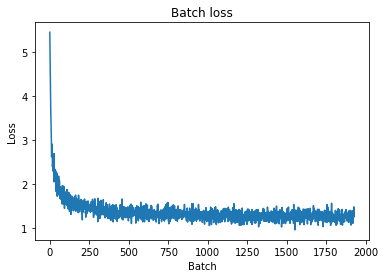

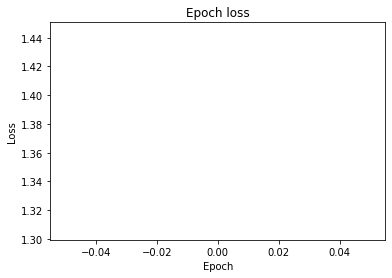

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun? the t the the the the the the the the the the the the the the the an t t the the the the the the t the the the the the the the the the the the t the the the the the the the the the the are the the the t the the the t t t the the the t athe t the the the the the the the an the the the the the the the the the t the the t the the the the the t t t the t the the the t t the the the the athe the the the the the t the athe the the the t the are t the the t t the the t the the the the the t the the the the the the the the t the the the the the athe the the the the the the the the the the the are the the the the the the the the the athe the the the the the the the ane the the are the the the the athe the athe the the the the the the the the athe are athe the the the an the athe the an are the athe are the are are are are are athe the athe athe athe athe the the the the the t the the athe the t the the the the t

100%|██████████| 1929/1929 [27:40<00:00,  1.16it/s]


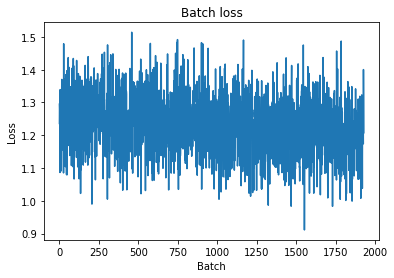

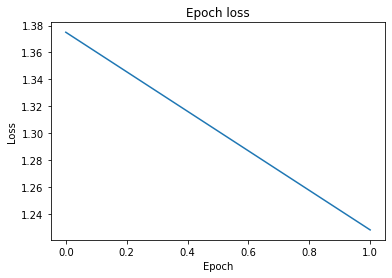

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
I st a the se t the t se the t the the the s are the an the an the the the se an an the the an the the the the the ane the the the the the an the an the the the an the the the the an the se the the the an the the the the the the the the the the the the s the the the s the the the the the the the an the the the the the the the the the the the the the s s s the the the the the the the the an s s the the the are the the the an the the the s the the the the the the the the the the the the the s s the the the the the the the the ane are the the the the the the the the the the the the the are are s the the the the the s the s s s s the the are s are s the s the the an the the s the are the the the the the the the the the the athe the an the an athe whe the an are the the the the are the the the s are s s are are the are are are the the the the the the the the the the the the the the the the the the the the th

100%|██████████| 1929/1929 [27:36<00:00,  1.16it/s]


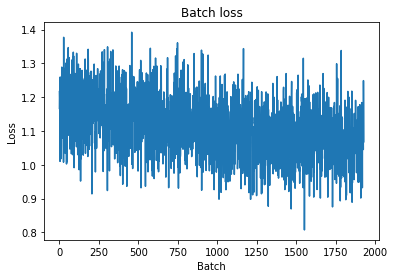

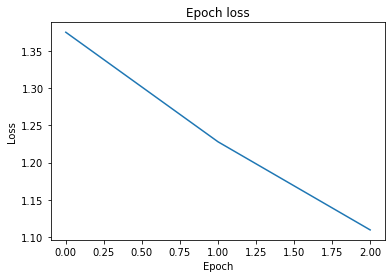

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
I w the wat a see tee te teer tee teallll the the the st and tear tear the the st the the st tear the st and tear the the the the st an teare the the the steare the the the the st and tear tear the the the ste the the the the the st and the the the st steare the the st the ste the the the st the st the t steat t temer the the the the st the the the st the ste the t the t sthe t the te st ste te t the the t t t the mp the the st mpe t te the t the t ste t the t te te the t t the t t t the t st s t the s te we t in the t te te the the t the t t t the t we t the t t t t t s s sthe we t in w t the w t w the t s t the t t t the s t s the we t t t s t the t t w t t t the the t w w t t t t the t t t t t the t t w t t the w t the the we we t the t the w w t t t t t s t t t w t t t w  w  athe t  t r we w s t t   t the the we t the the the the t the the t t t t t t t t t t the t the t the t the t the t the t the 

100%|██████████| 1929/1929 [27:30<00:00,  1.17it/s]


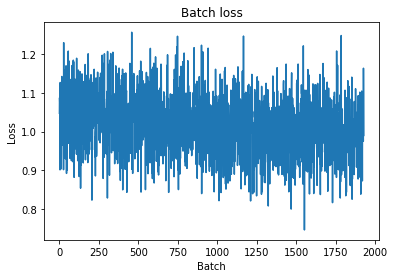

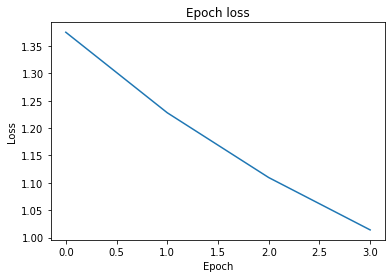

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
It was tel teally tear teallly the teat spperend tear the teat tealll tear tear alll tear teall tear tear tealll the tear ar and tear the and tear and tear the and teat and teall the teat tear and teall the tear tear the teat the and and tear tear teak the the the sppeare tear teall the tear the tear tear all the to tear t pperstion the the t persing all t the t a skeall t the t the t the skeat t t the ap ar and t t ak t ak wallll t ak t ak w w the b t w t the w t ak w t t t t ak le w rk w at w a w w w w le le lle a t ak le t llle w t w a t w w w w w w w w w w t t w w w le t t w le le  w  le    w  w  w  w  w  t                                                                                                                                                                                                                                                                                                          

100%|██████████| 1929/1929 [27:31<00:00,  1.17it/s]


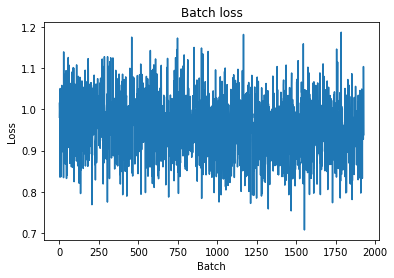

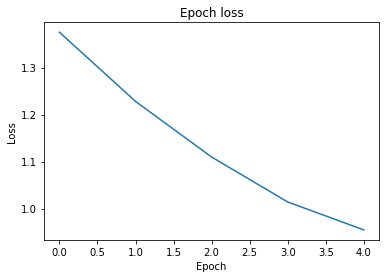

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
If you cke a ppper the pppersing and the ampler and templer the specing a s a w th compent temple the speed a t skeed t the sppered and teather templer the sperens. I w heaver a w ther as a spening t the sppere temp the temer the spening t temp the temple temend the temper the semend temp the temend the temend the temens the temend they temener the te semend the tement then temer the tementher the the temener temens the temend the te the t teme the t te s wee t t teemp te t t t seempp terse se se t t t was w bee amp ang and t t w t w the w w w w the w w w w w w w w w w the the w w w w w w w w w w w w w w w w w w w he he w w w he w rk w w w w w w w w w w w w      w   w   w w w  w w w    w      w w w w       w  w w                                                                                                                                                                                                  

100%|██████████| 1929/1929 [27:49<00:00,  1.16it/s]


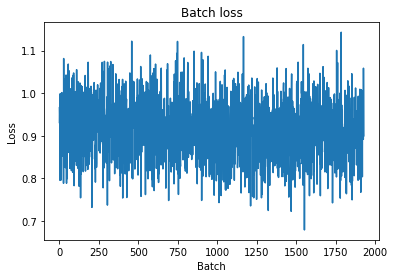

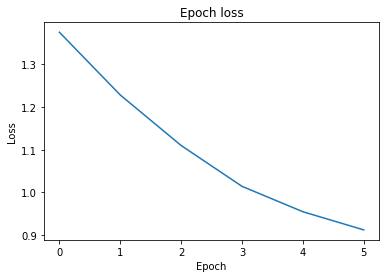

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
It's week the werk the tes tes tess tess tess tes tess text tes text tems temp tes temp tes temp templere the spensinced temps tess temps temp the tems templer templener.

Prompt 1: Hello world, 
Model output: Hello world, hend wel w dvepent wek wek wek wek wek te?
I'm would we the ckep the weark tes tes tess tess tes tess tess tess texp tess tes tess texp text tess temp tess temp tess temp therer temss and templerent them spensing temples temples temss templenes them templened templements templenes them semend temens tems templementing them semens temples tems templenes temss templenenes themes temens temens temens them censent t weer the temend temens they temener ther te semend temeneng tenenes tesend tend teneneners theng thes theng tensenereng tenerereses thens.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
It's see tess tes tes tess tess tess tesst tes tesst temp tess tess tess 

100%|██████████| 1929/1929 [27:34<00:00,  1.17it/s]


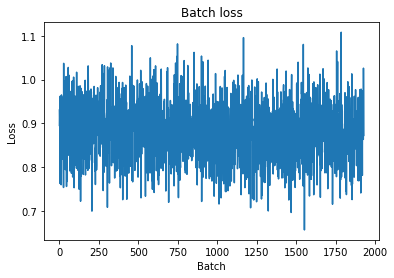

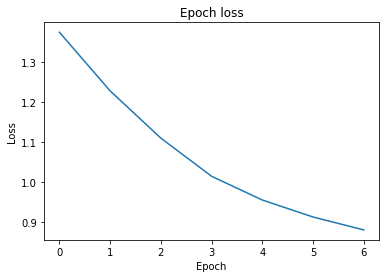

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
It's wek the specifical and tes the specire as a sk tess of the specifical and tes tess tess temp tems templere. It's all tem them specing tems temps temples tems templement them spended tems tems templeter.

Prompt 1: Hello world, 
Model output: Hello world, welppsppent wevent tems and teps wek wek wek wek wek teps?
I'm well k we wek welll we tes tes tess tess tess tess tess tess text tess as teg tess as ask tess tems temp tems temp templere.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
It maked ther arbout and temps tesss and tess tess and tess tess tess tess tess tess tess tess tess. It's telly tems tess tess temp tes tesss tess tess temp tess temp tess. It'm well tems temend temend tems templenes temend tems templenes tems temply templementent temens temss and tels templeneres templenes templenes. It's t well t be tement temens tement tementer the spenced tens tement them temente

100%|██████████| 1929/1929 [27:34<00:00,  1.17it/s]


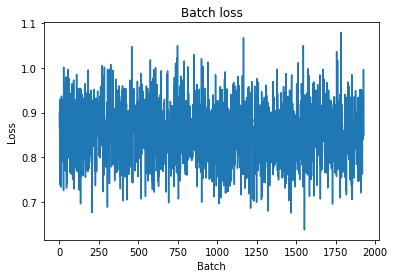

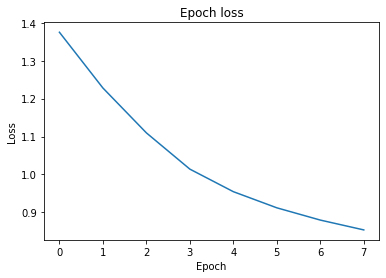

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
It's would be there arbout tess the specific and tes tess tess tess tess tess tess tess tess tess tem tems temples tems templere.

Prompt 1: Hello world, 
Model output: Hello world, I wekp wek wek?
I waked have telk the mp bession and tes tess tess tess. It's all tess tess tess tess tess tess tess tess tess temp the specifically tess temps tess. It's all tess tess temp them semens tems tems temply temens templens temply them temes temples tems templenes.

Prompt 2: How to use ChatGPT?
Model output: How to use ChatGPT?
I was tes thererer and and tesk of tess. It's and there ally arbout team tess tess. It's any tess any tess and tess tess temp the specing tess. It welll we tess temp the specific tess. It'm the spensifically and tess temp the specific and tessem temps templing the specing and temples temples.

Prompt 3: My code does not work. What should I do?
Model output: My code does not work. What shou

100%|██████████| 1929/1929 [27:33<00:00,  1.17it/s]


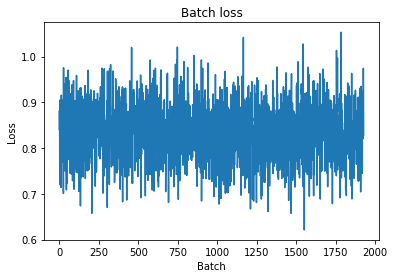

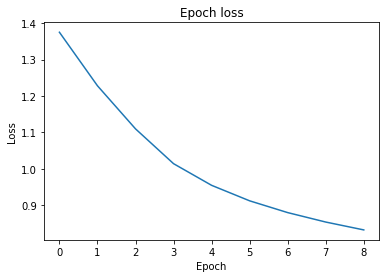

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
If you want the between there and test the specific in test test temp the spensific and tess temps templing the specific temps the specifically and seems. It's well the specific and temples the specific and temples templication the cerceses and temples templication temples the cemplent tems. It's seend temples the becomend and templenes the specifically cerment the tementhererers and the spendencents of the temens them temens them the temen theres theseres.

Prompt 1: Hello world, 
Model output: Hello world, wek wek head wek theres? 
I way want th specing the specific and tes test tes tes temp tes temp the spend tems templing temples the specifically and tes templication temps. It's all templeres the templication temps templication temps templication temples. It's tell templens the specifically and tell temples templicate temps temples. I well well them temens tempeneres them tementic the tem tement the

100%|██████████| 1929/1929 [27:39<00:00,  1.16it/s]


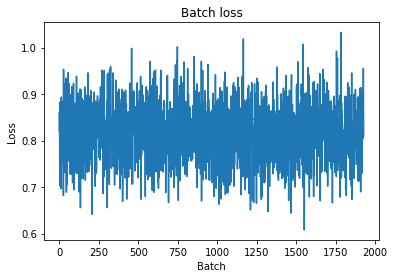

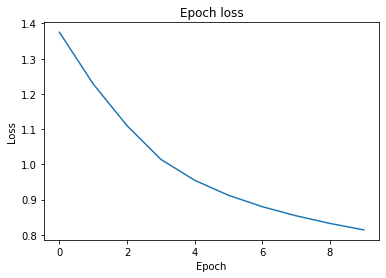

Prompt 0: Why does Earth orbit the Sun?
Model output: Why does Earth orbit the Sun?
It's wek the specific and the specific and test test test temp the spend tems the specific in test and temples of test templing the specific and templines. It's all temples the specific and tell tems templication temps the specific and tell temp temples. It's all temest templines templines the specing and templens the specifically and templenes the specific and the spensing and the specting and the templerent the tempserent.

Prompt 1: Hello world, 
Model output: Hello world, wek hepspopents?
It's would bener and there arbout there arbout therem and tess the spensifically webset the specifically and specific and tell temp the specific and temps of tes. It's all the specific and temps templic templications and tell temp the specific and tell templement templents. I well we templened the cercent and templent the templent them tementing the celps and tementherer.

Prompt 2: How to use ChatGPT?
Model output

  7%|▋         | 135/1929 [01:55<25:34,  1.17it/s]


KeyboardInterrupt: 

In [23]:
model.train()

epoch_losses = []
for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}")
    
    batch_losses = []
    for data in tqdm.tqdm(dataloader):
        optimizer.zero_grad()

        data = data.to(device)

        output, loss = model(data, True)
        
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

        
    epoch_losses.append(sum(batch_losses)/len(batch_losses))

    plt.plot(range(len(batch_losses)),batch_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Batch loss")
    plt.show()

    plt.plot(range(len(epoch_losses)), epoch_losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Epoch loss")
    plt.show()

    torch.save(model, prefix_models+f"model_E{epoch}")

    with open(prefix_models+"losses.txt", "a") as f:
        f.write(f"{epoch_losses[-1]}\n")
    
    
    with torch.no_grad():
        for i, prompt in enumerate(prompts):
            print(f"Prompt {i}: {prompt}")
            output=generate(prompt)
            print(f"Model output: {output}")
            print()



In [ ]:
model = torch.load(prefix_models+"model_E9")

with torch.no_grad():
    for i, prompt in enumerate(prompts):
        print(f"Prompt {i}: {prompt}")
        output=generate(prompt)
        print(f"Model output: {output}")
        print()


In [ ]:
import builtins
while True:
    prompt = builtins.input(">>> ")
    output=generate(prompt)
    print(f"Model output: {output}")
    print()